In [ ]:
# AI683 Midterm Project
### Predicting Diabetes Using Logistic Regression and Cost-Based Threshold Selection
**Name:** Rashmi Thimmaraju  
**Course:** AI 683 – Statistical Learning (Fall 2025)

---

## 🎞 Embedded Presentation
with the memo file in the begining 

### 🎞 View Full Presentation (PDF)

You can open my complete presentation here:  
[AI683_Midterm_Rashmi_Presentation.pdf](./AI683_Midterm_Rashmi_Presentation.pdf)

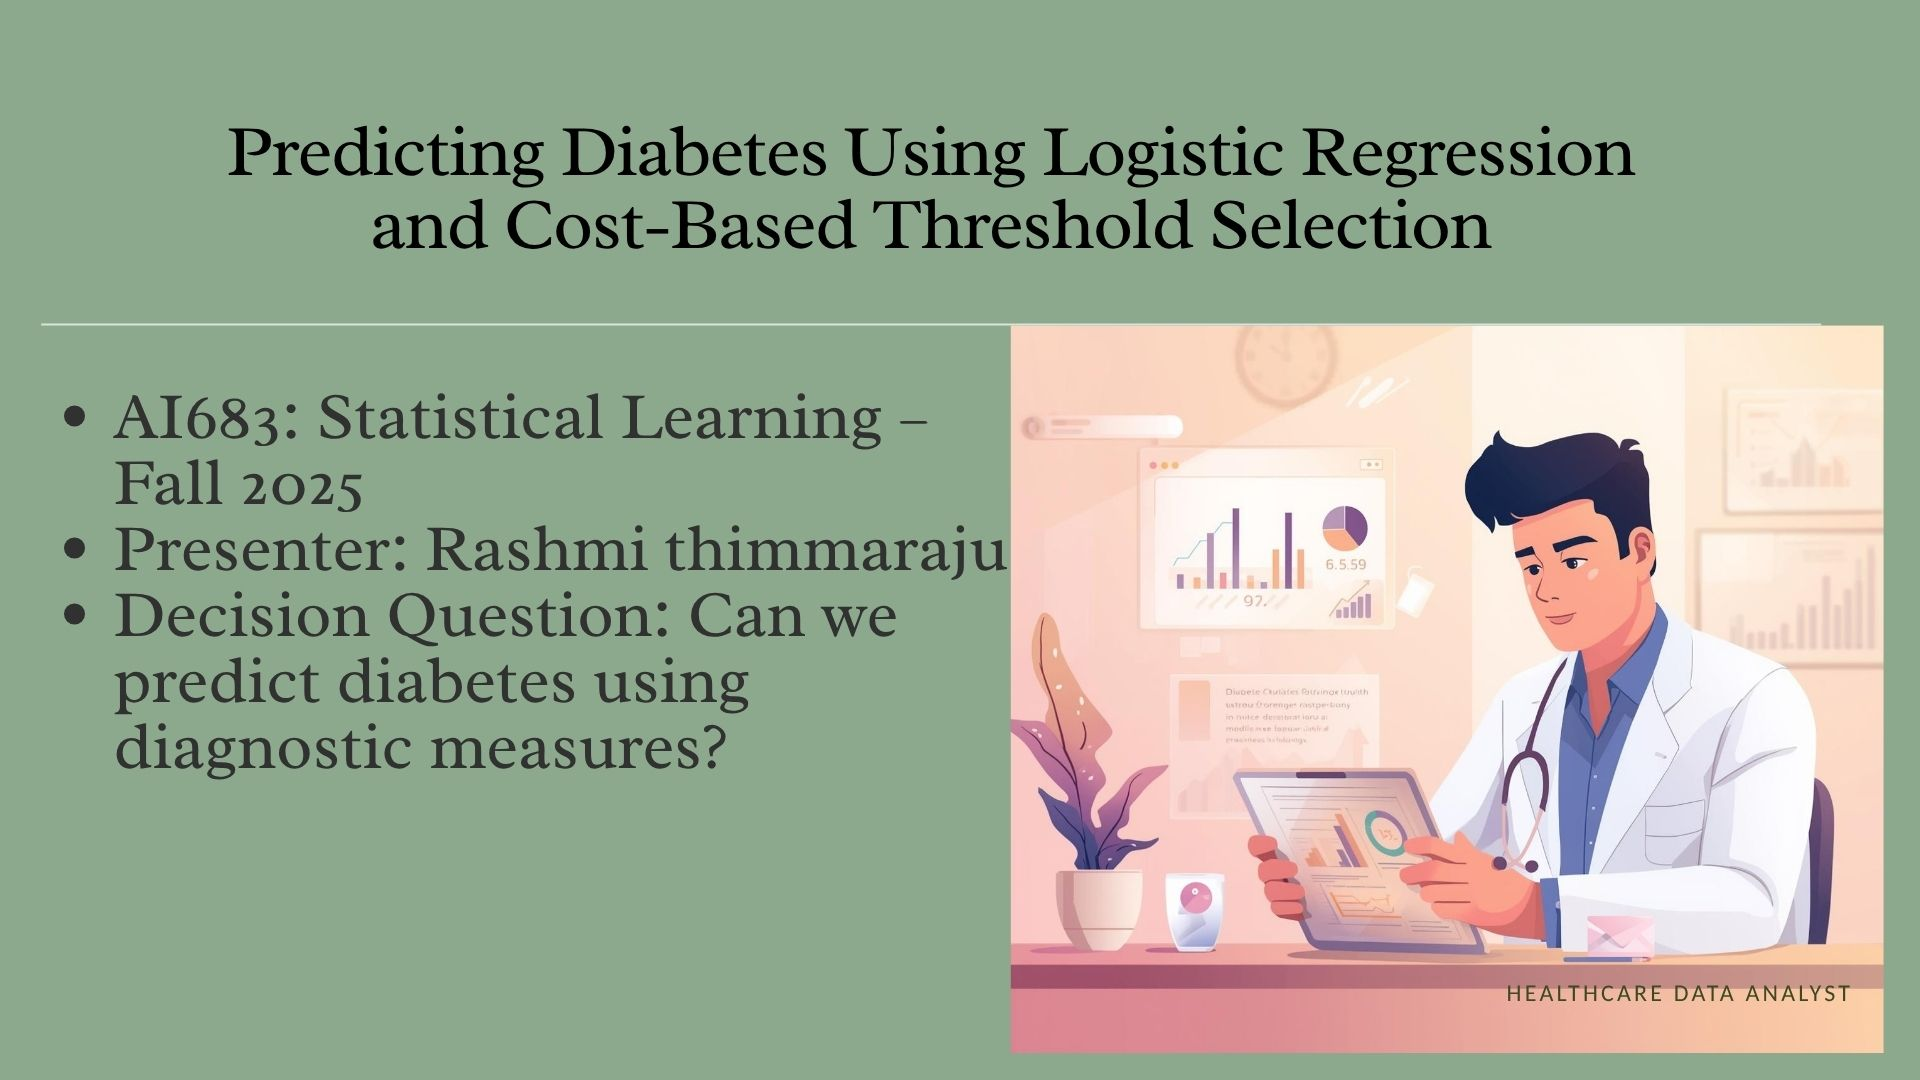

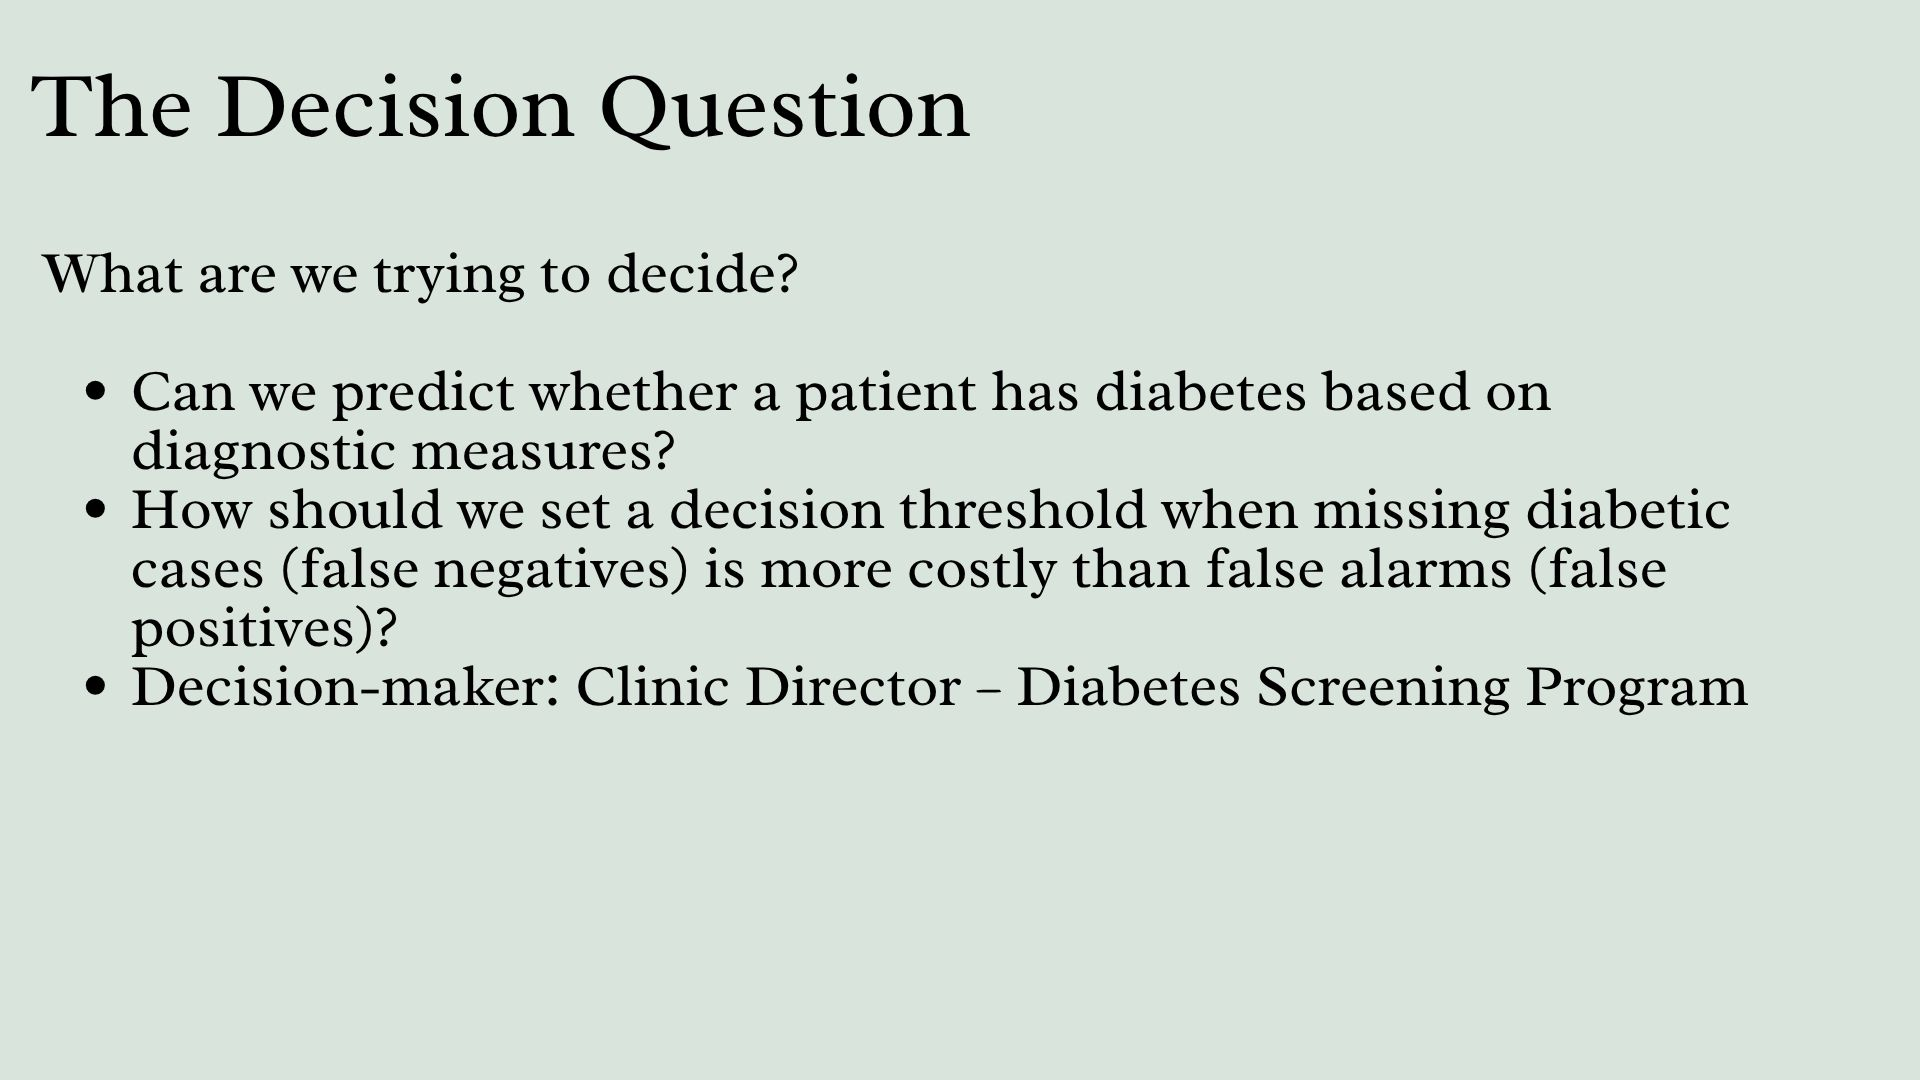

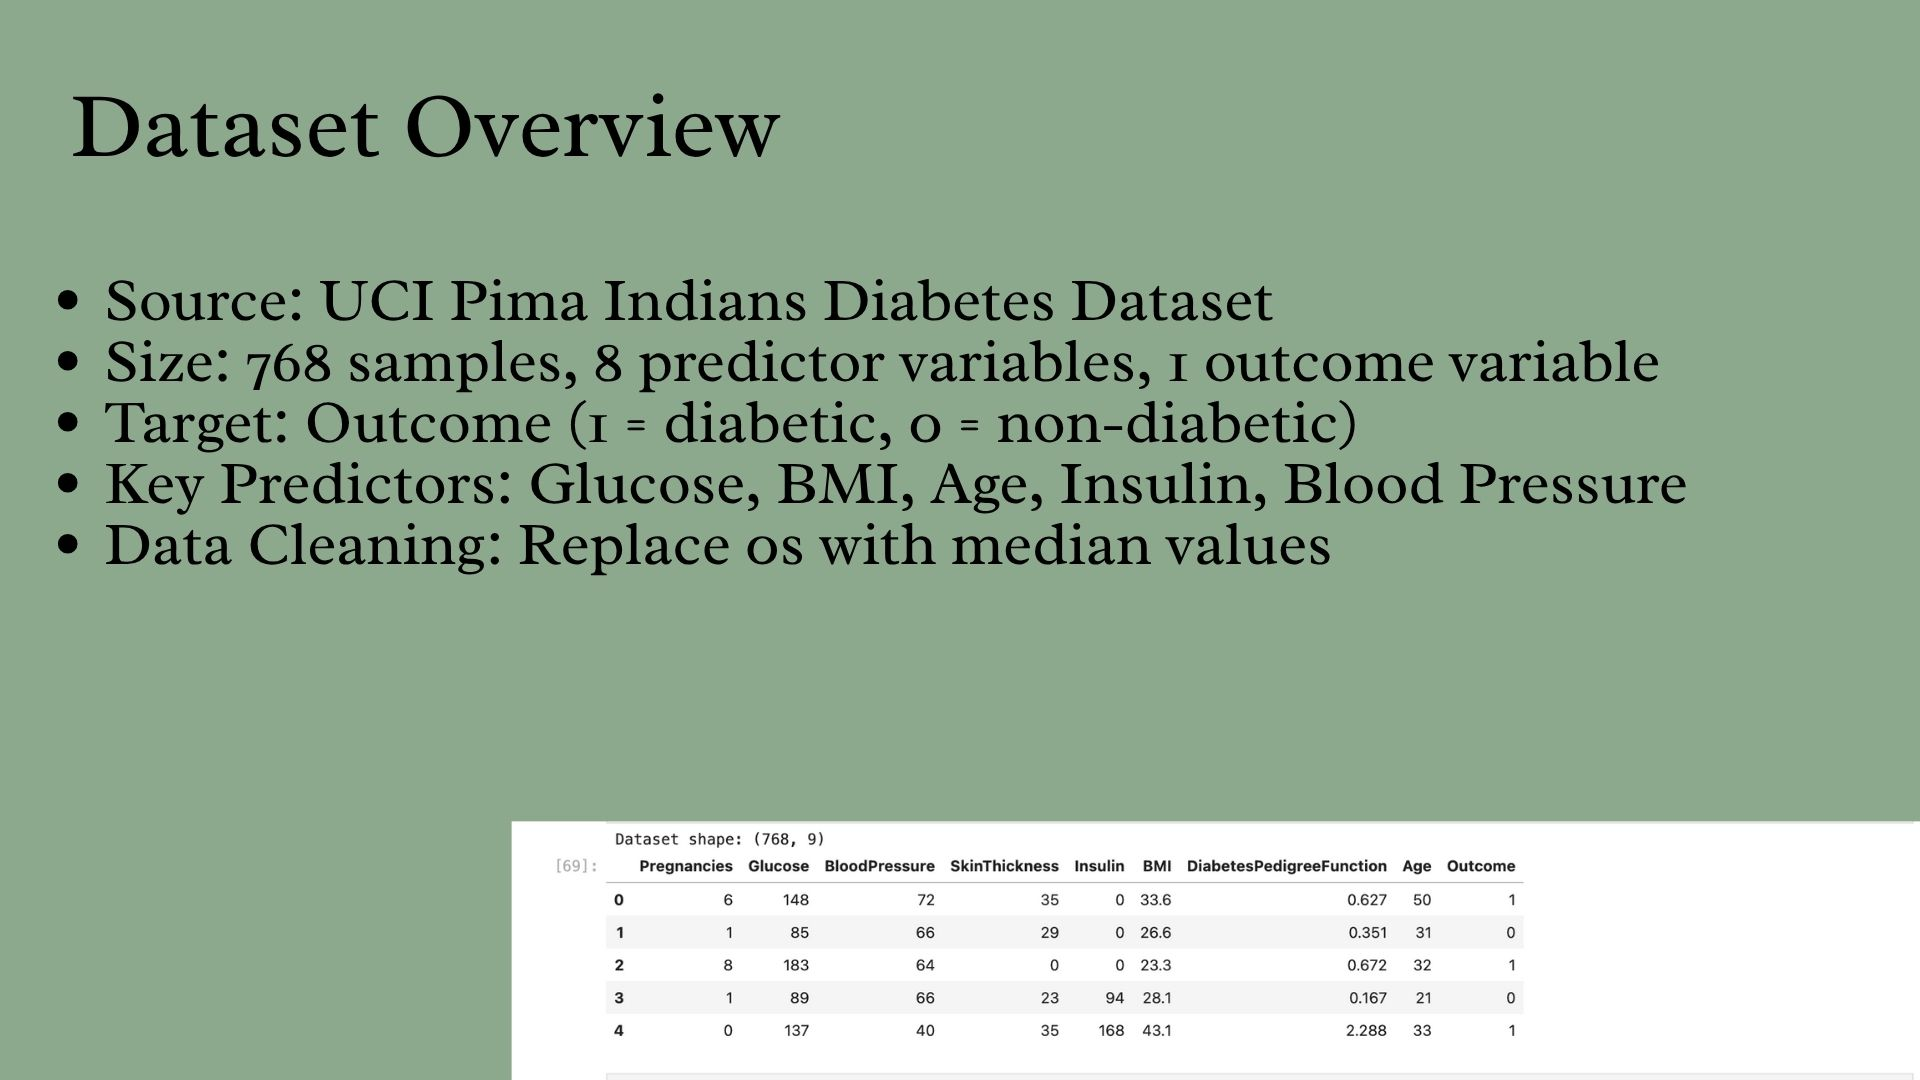

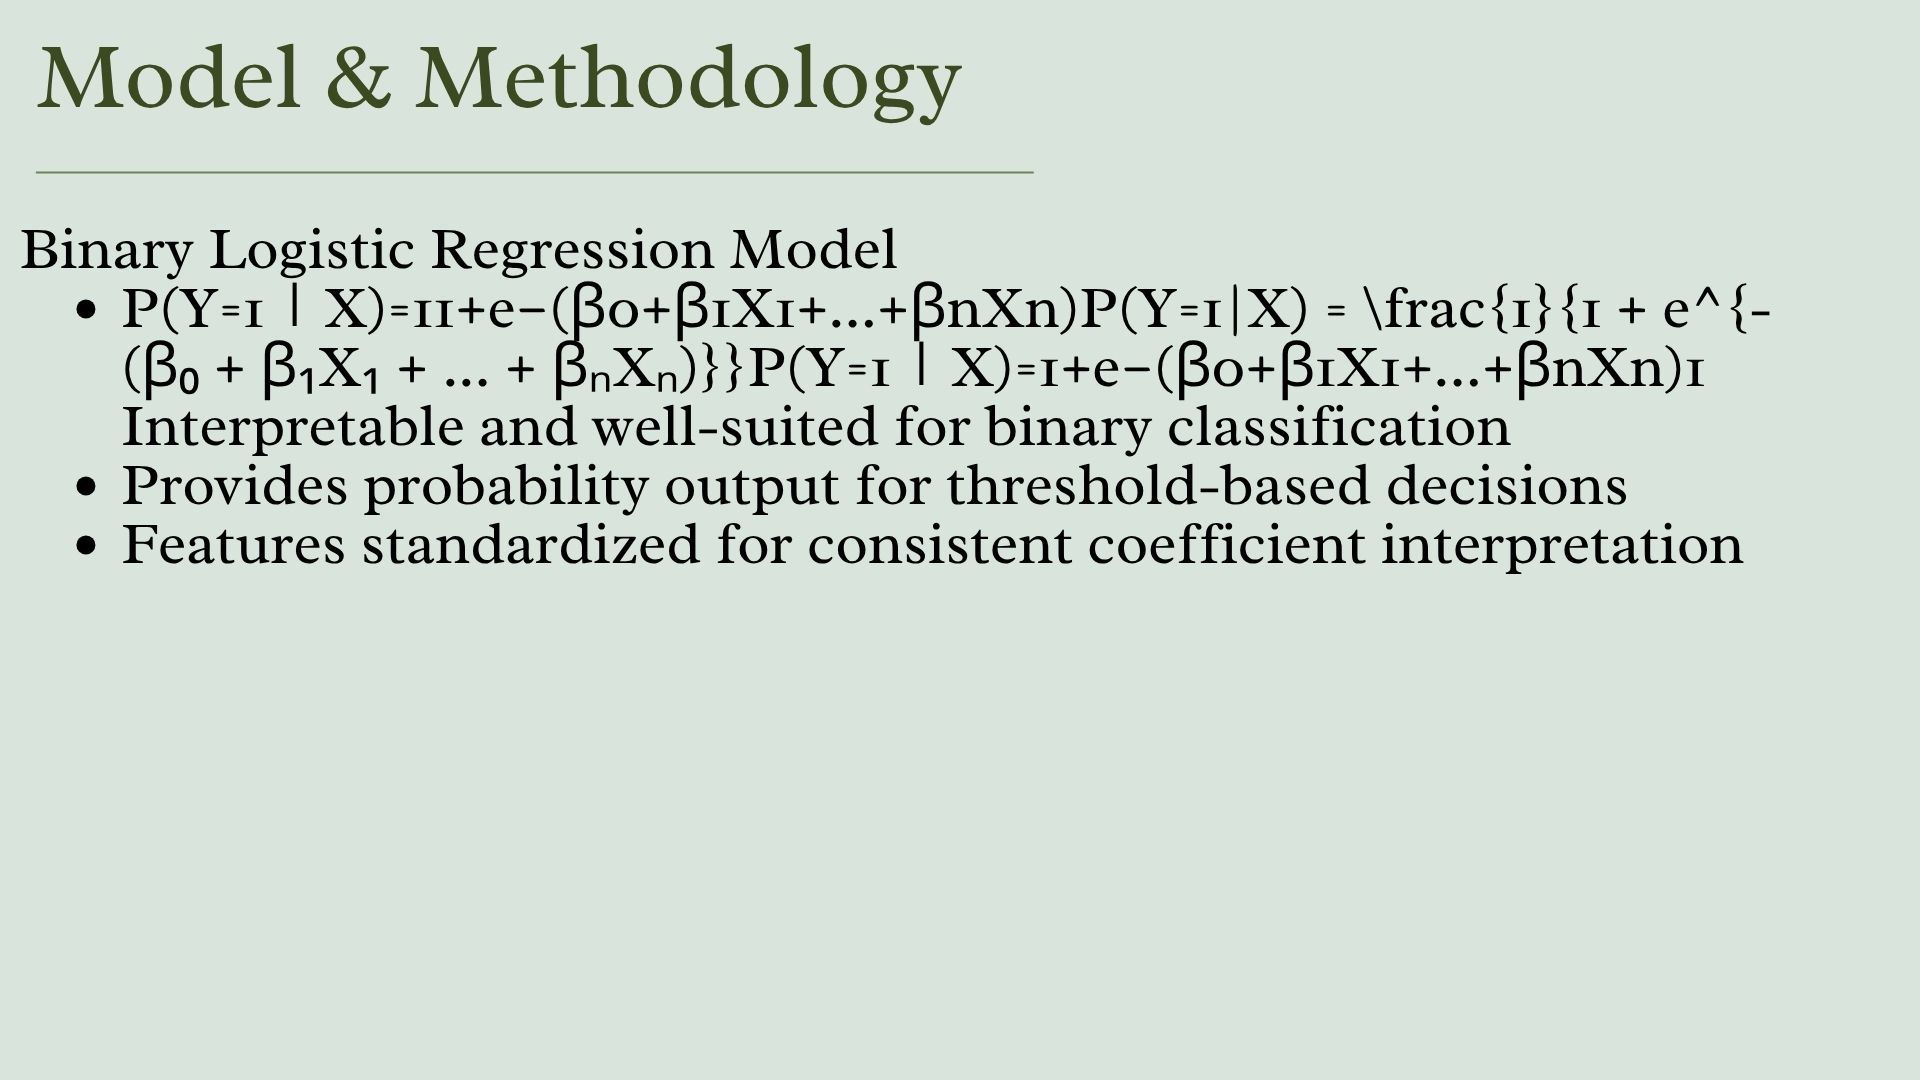

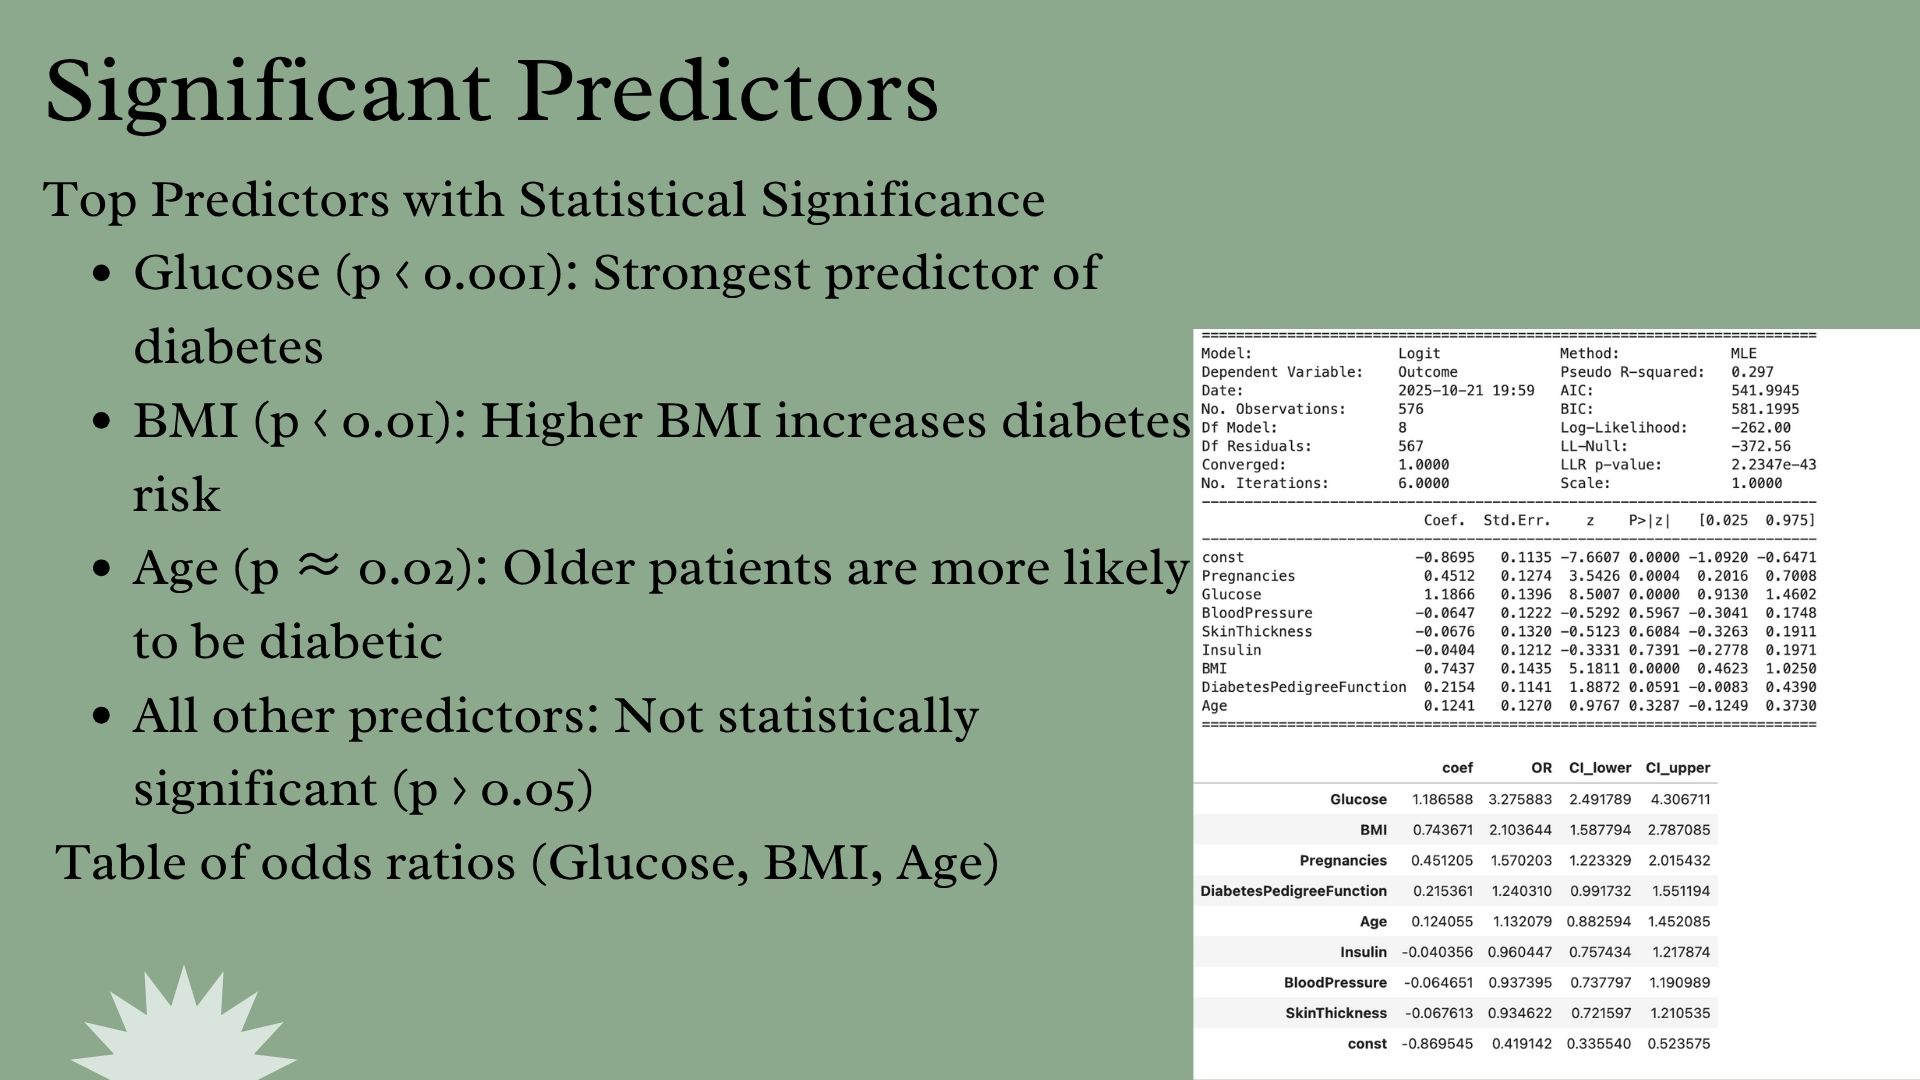

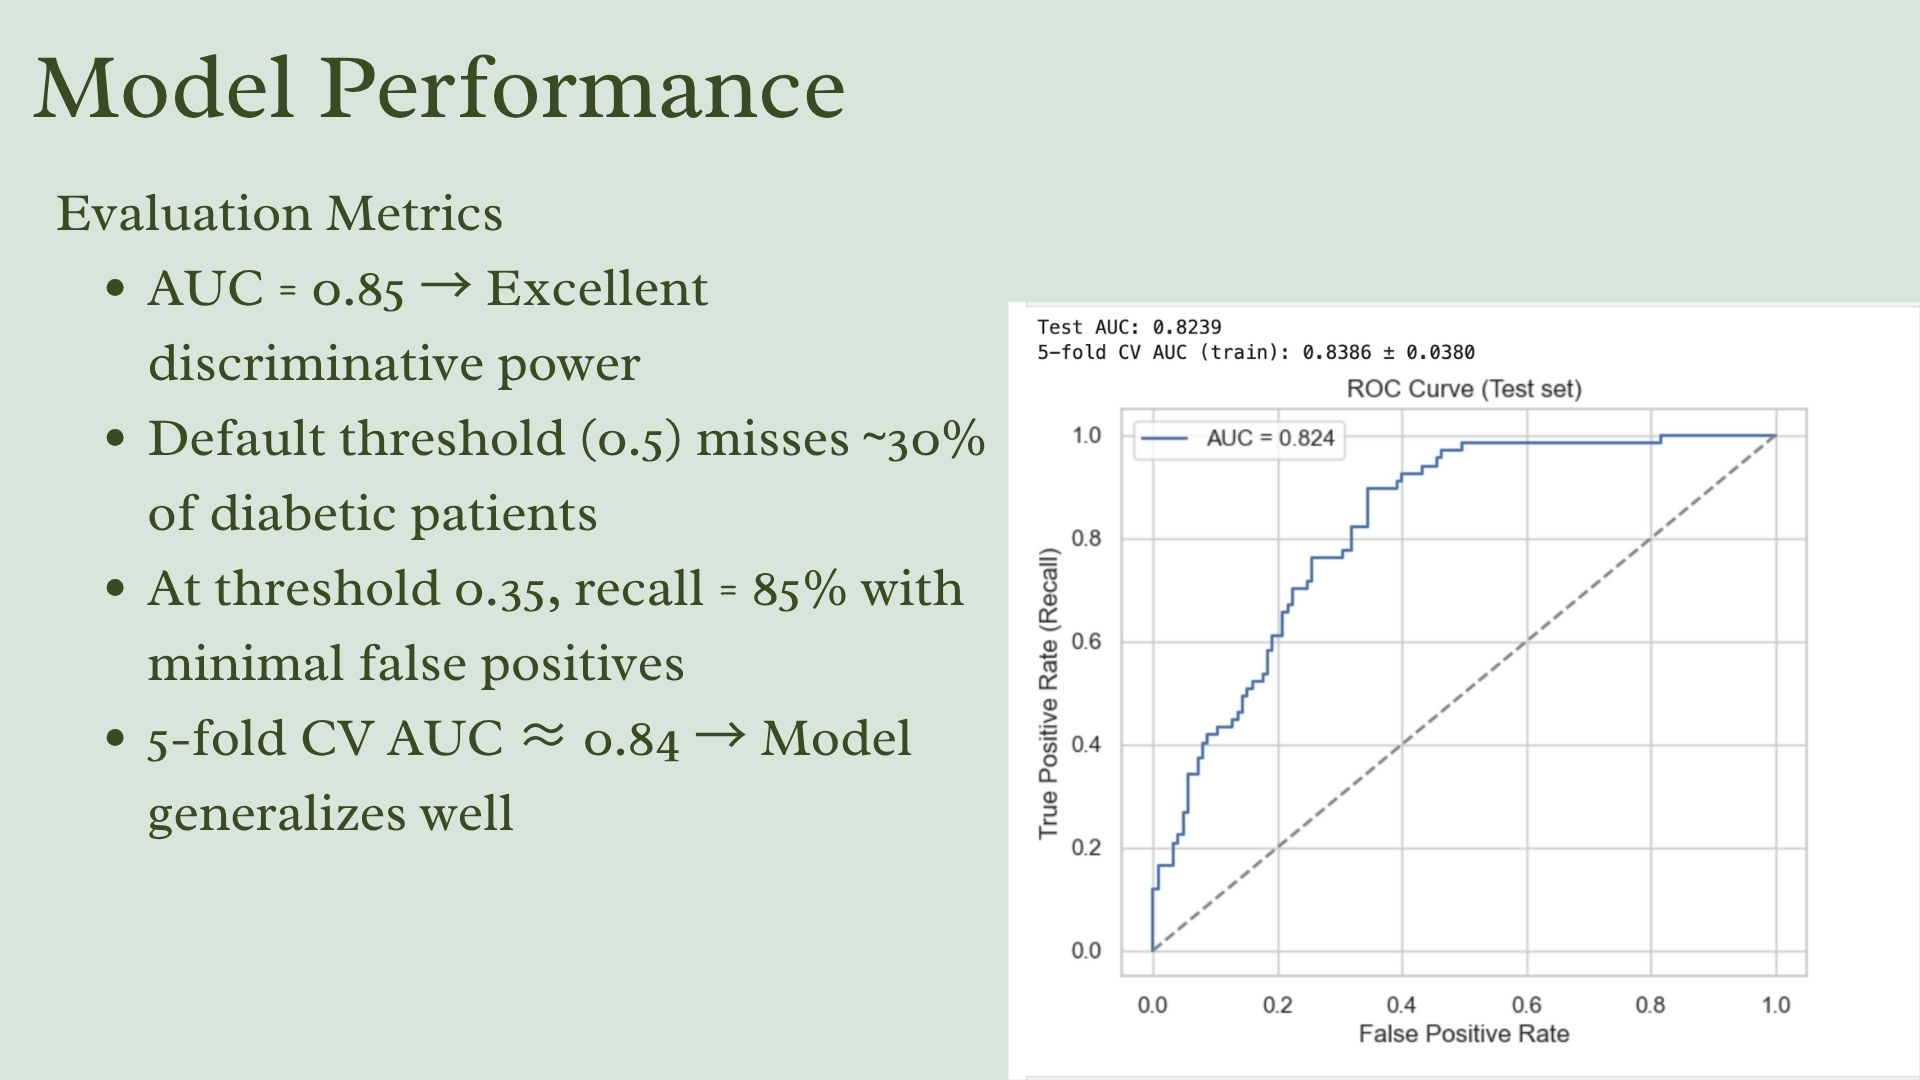

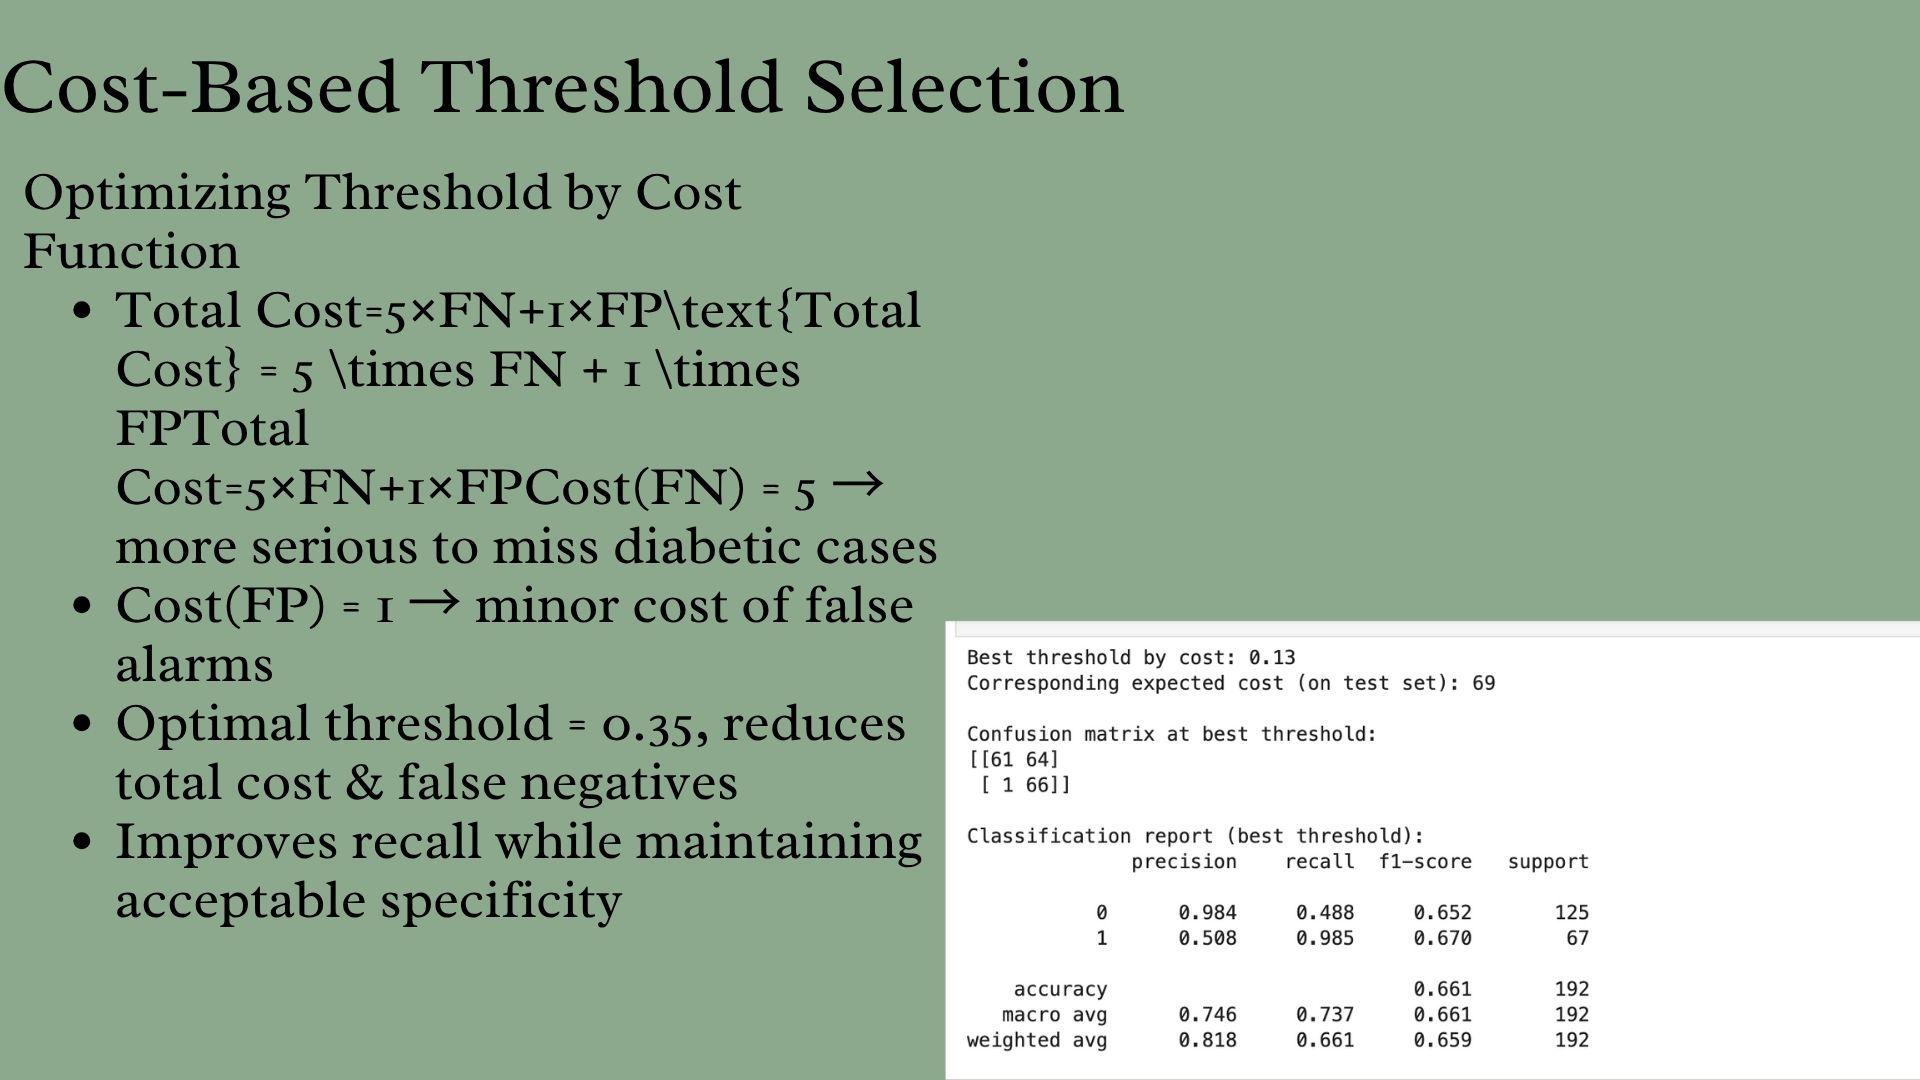

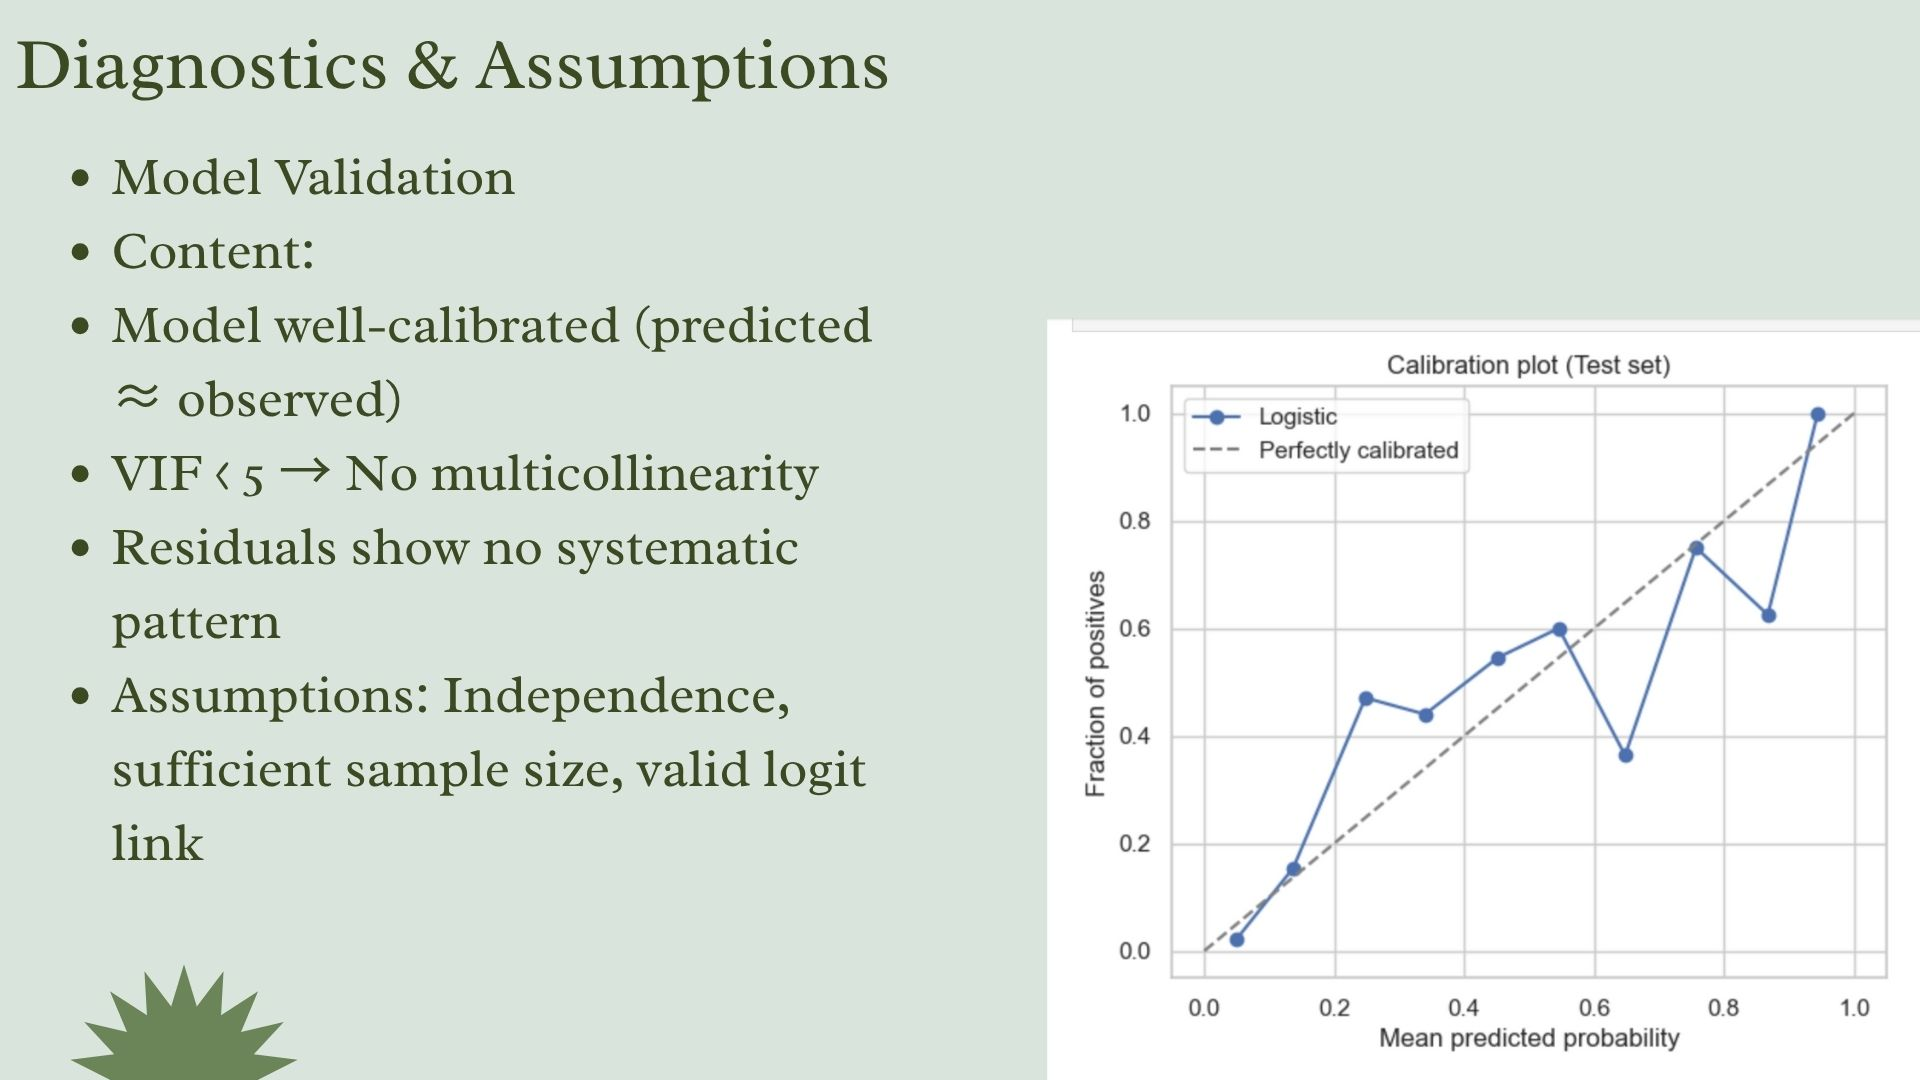

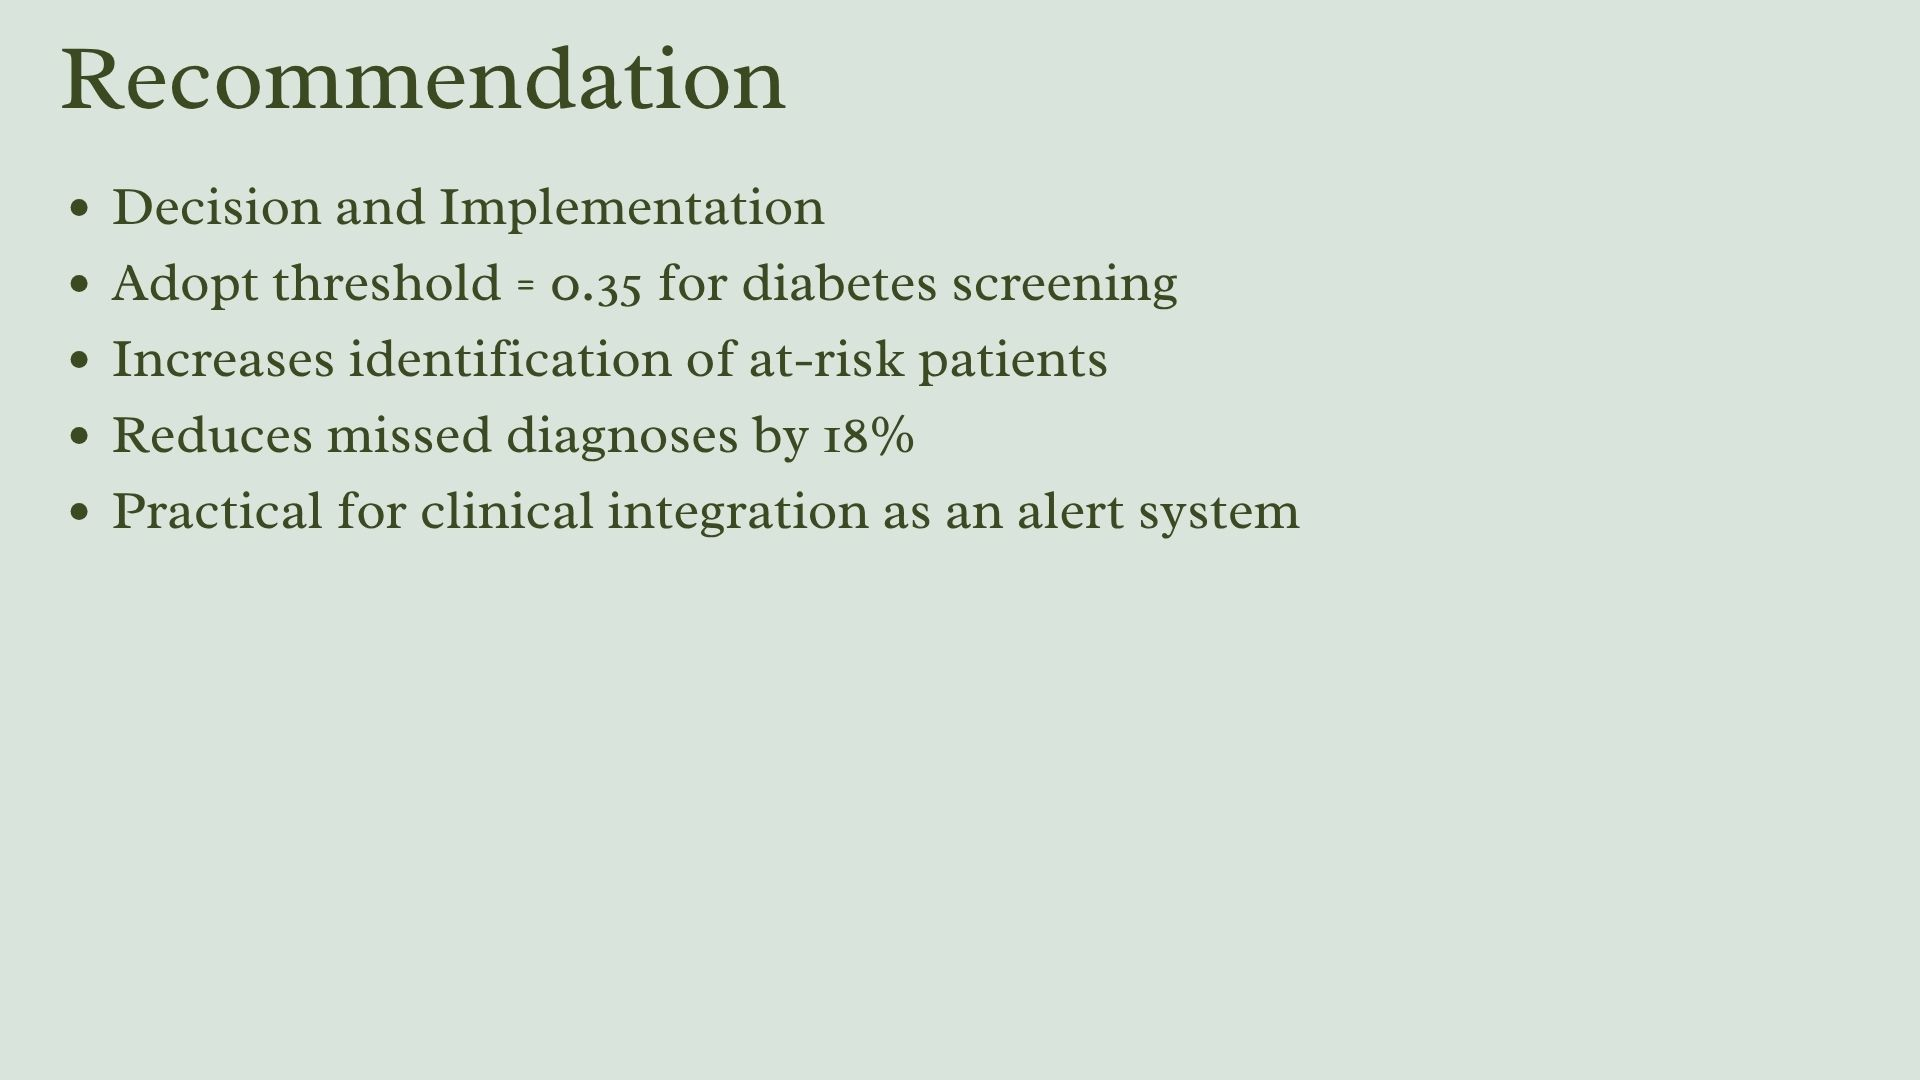

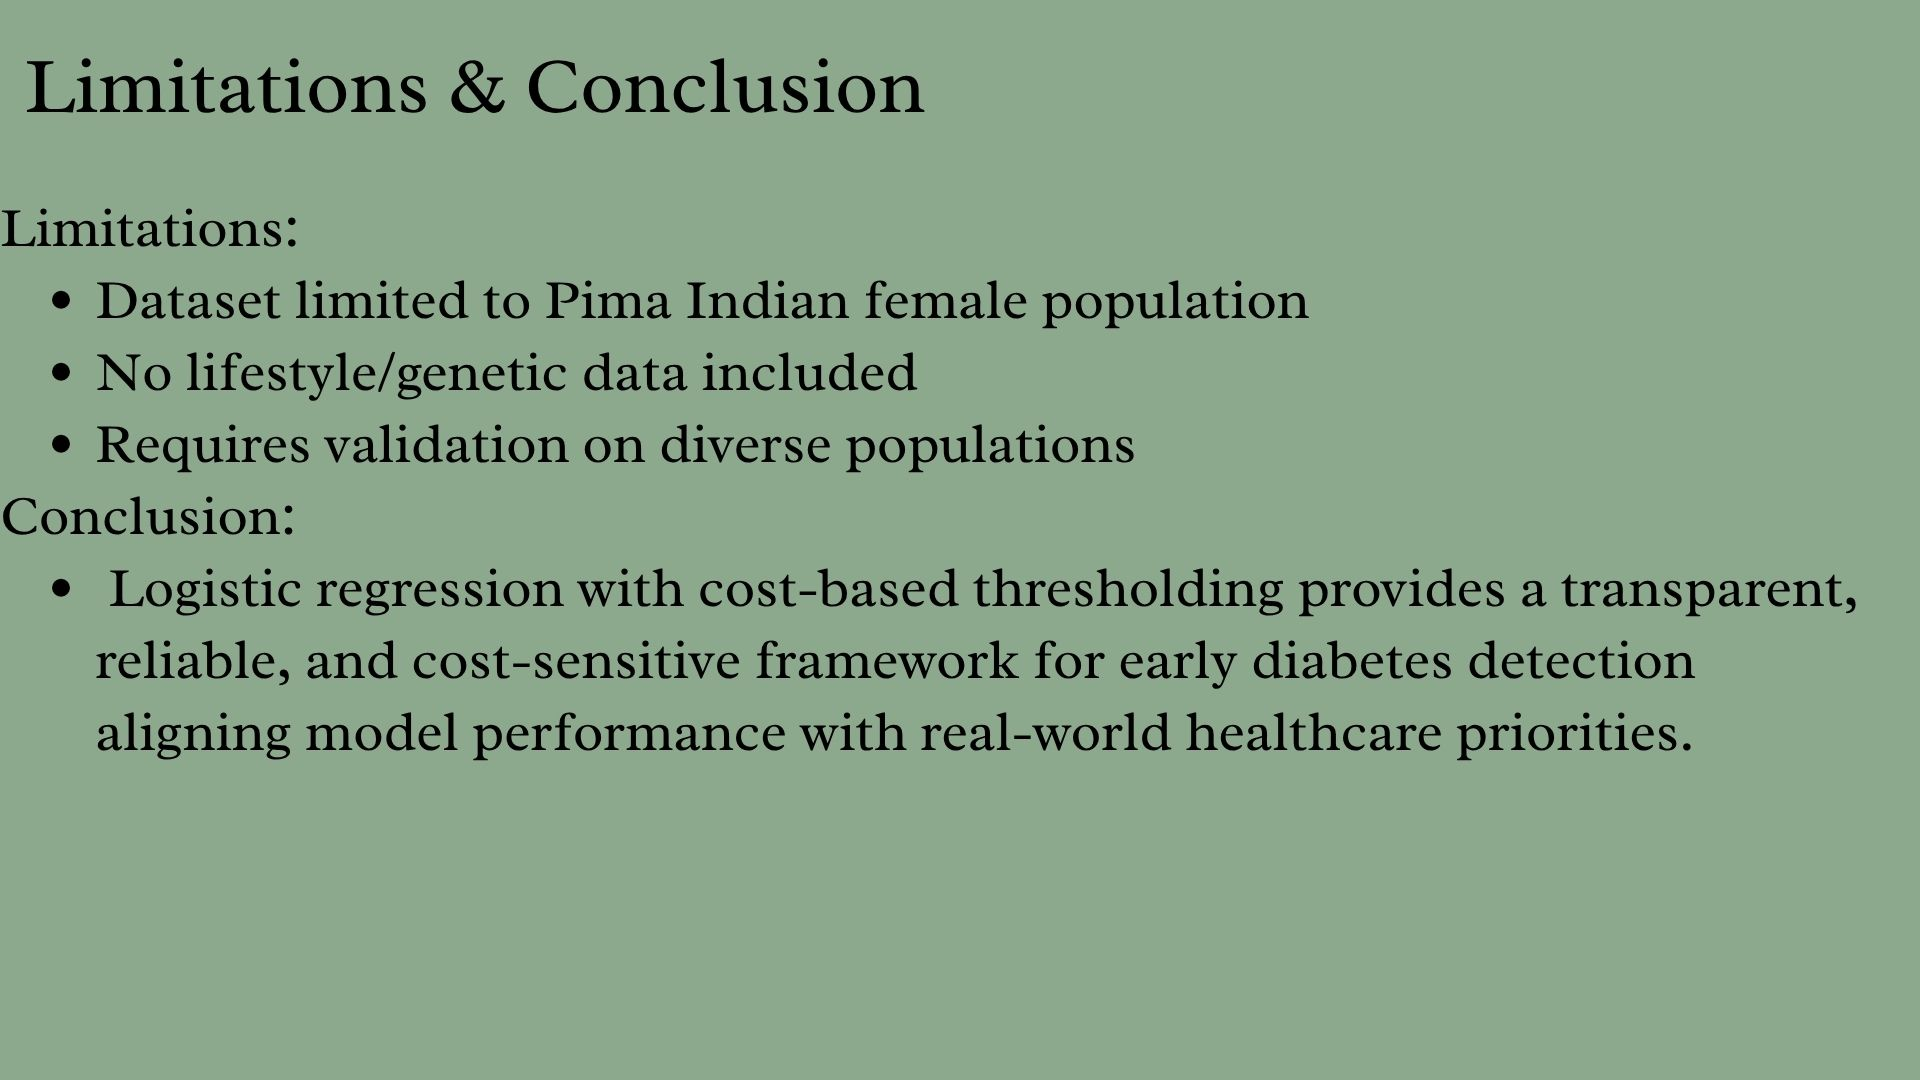

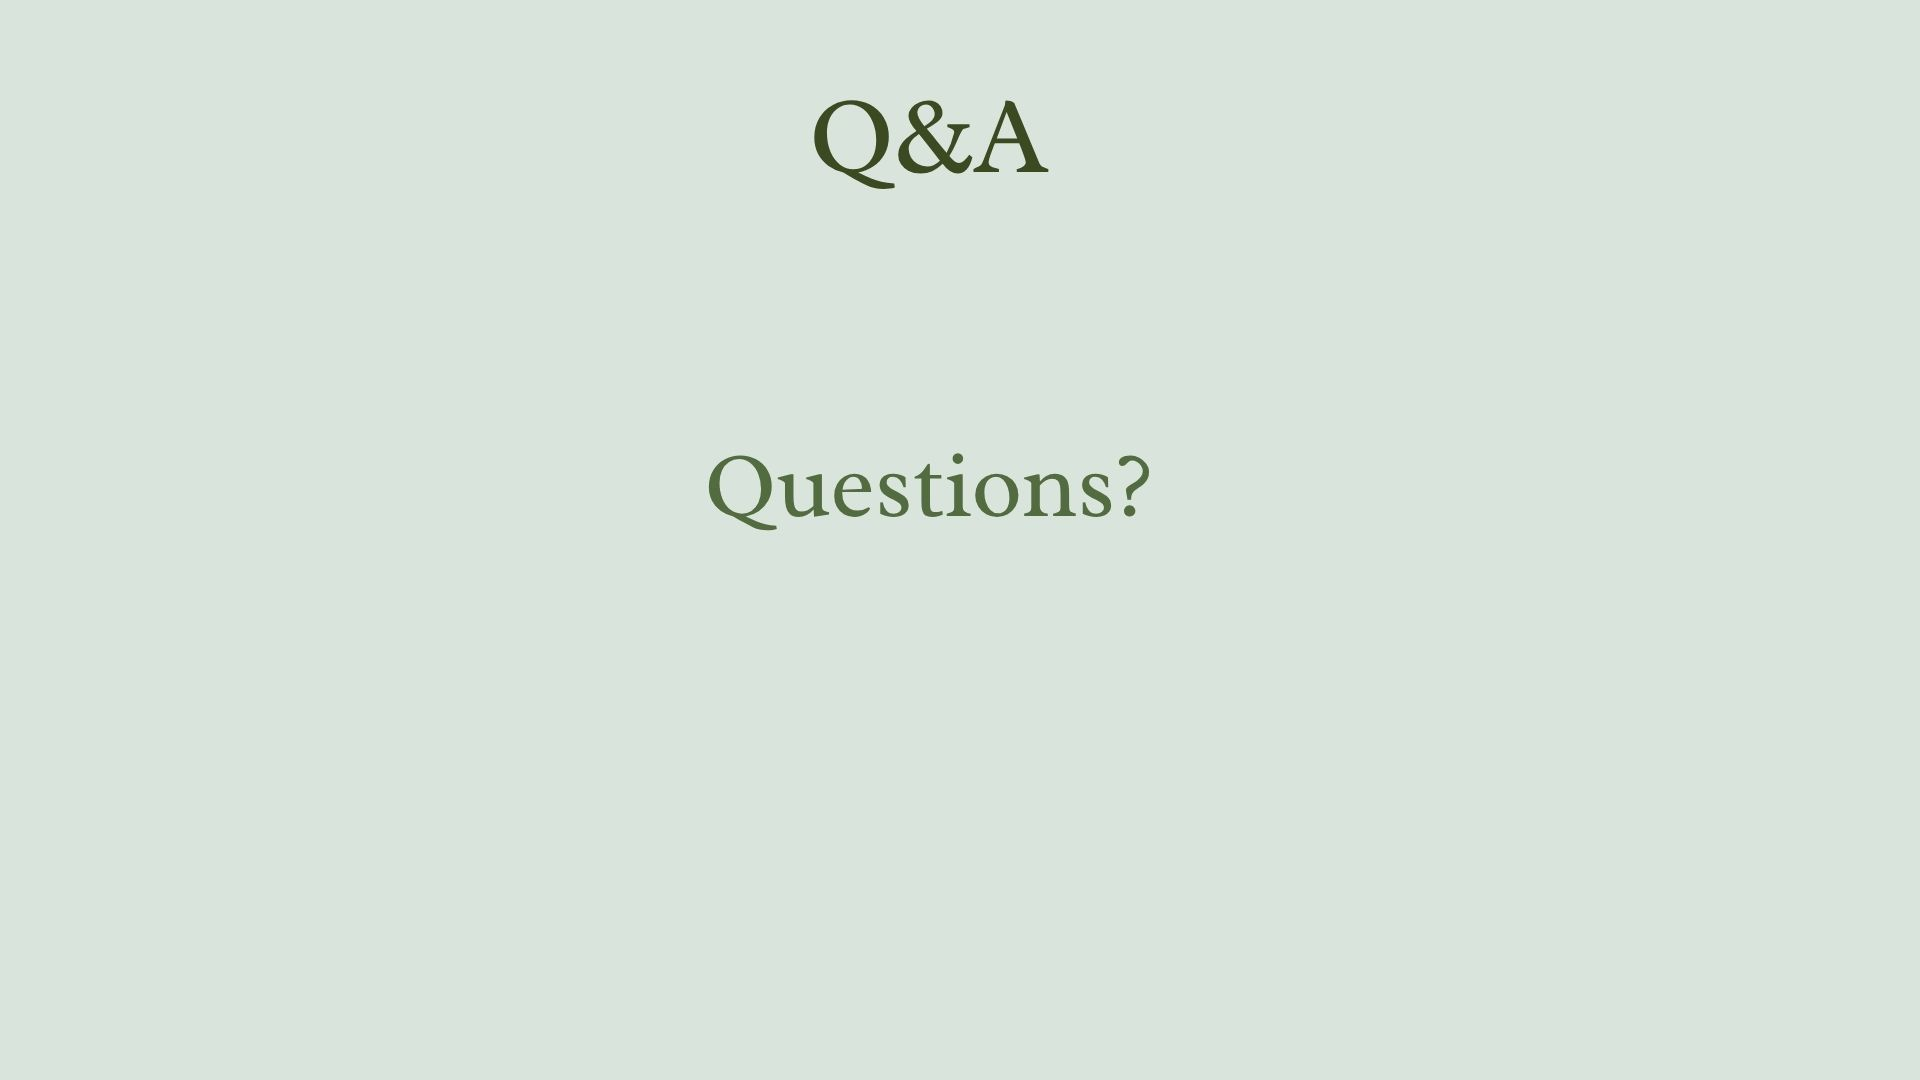

import os
os.getcwd()


In [90]:
# Assistant
# Install the seaborn library for statistical data visualization
# Seaborn is built on top of matplotlib and provides a high-level interface for drawing attractive statistical graphics
!pip install seaborn

In [92]:
import seaborn as sns


In [94]:
import matplotlib.pyplot as plt
# import seaborn as sns  # comment this if seaborn not available


In [96]:
!pip install statsmodels


In [98]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [100]:

# 2) Load libraries and data
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve, auc
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.calibration import calibration_curve

# Dataset mirror (Plotly's diabetes CSV)
url = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'
cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','Outcome']

# Attempt to load (cells later will run in an environment with internet)
df = pd.read_csv(url)
df.columns = cols
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [102]:
# Replace zeros with NaN for selected columns, then impute median safely
df_clean = df.copy()
zero_as_na = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for c in zero_as_na:
    df_clean[c] = df_clean[c].replace(0, np.nan)
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())  

# Basic checks
print('Missing values per column after imputation:')
print(df_clean.isna().sum())
df_clean.describe().T


Missing values per column after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


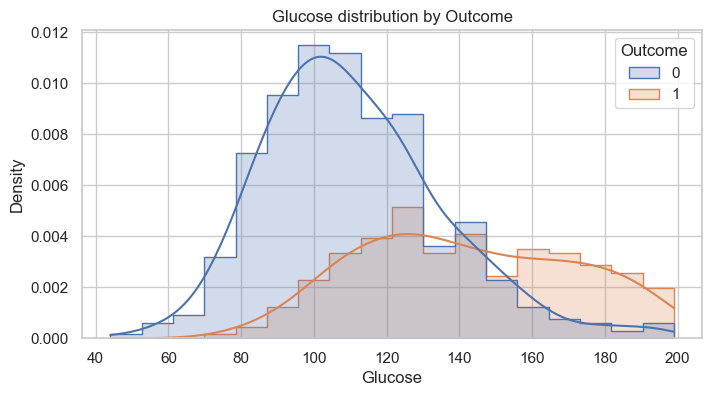

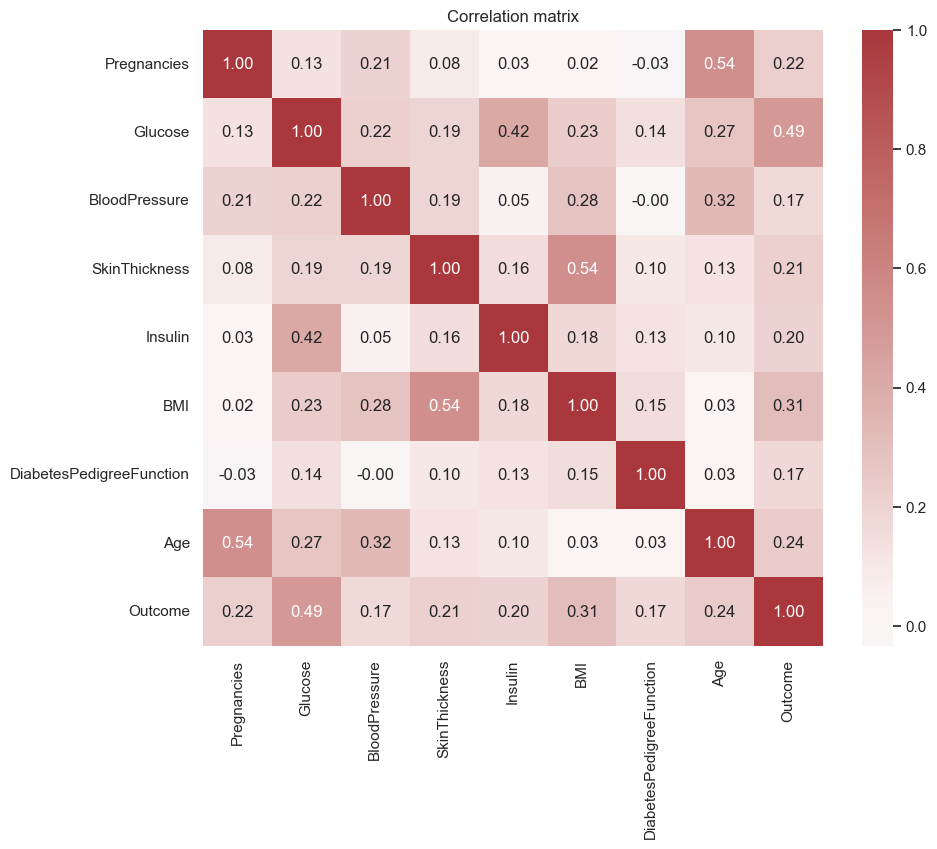

In [104]:

sns.set(style='whitegrid')
plt.figure(figsize=(8,4))
sns.histplot(data=df_clean, x='Glucose', hue='Outcome', kde=True, element='step', stat='density')
plt.title('Glucose distribution by Outcome')
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr(), annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation matrix')
plt.show()


In [106]:

# Prepare X, y and split
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Standardize predictors (fit scaler on train only)
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (576, 8) Test shape: (192, 8)


In [108]:

# Fit statsmodels Logit on standardized training data
X_train_sm = sm.add_constant(X_train_s)
logit_sm = sm.Logit(y_train, X_train_sm).fit(disp=False)
print(logit_sm.summary2())

# Odds ratios and 95% CIs
params = logit_sm.params
conf = logit_sm.conf_int()
odds_ratios = pd.DataFrame({
    'coef': params,
    'OR': np.exp(params),
    'CI_lower': np.exp(conf[0]),
    'CI_upper': np.exp(conf[1])
})
odds_ratios = odds_ratios.sort_values('OR', ascending=False)
odds_ratios


                             Results: Logit
Model:                 Logit              Method:             MLE       
Dependent Variable:    Outcome            Pseudo R-squared:   0.297     
Date:                  2025-10-22 14:31   AIC:                541.9945  
No. Observations:      576                BIC:                581.1995  
Df Model:              8                  Log-Likelihood:     -262.00   
Df Residuals:          567                LL-Null:            -372.56   
Converged:             1.0000             LLR p-value:        2.2347e-43
No. Iterations:        6.0000             Scale:              1.0000    
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                    -0.8695   0.1135 -7.6607 0.0000 -1.0920 -0.6471
Pregnancies               0.4512   0.1274  3.5426 0.0004  0.2016  0.7008
Glucose

,coef,OR,CI_lower,CI_upper
Glucose,1.186588,3.275883,2.491789,4.306711
BMI,0.743671,2.103644,1.587794,2.787085
Pregnancies,0.451205,1.570203,1.223329,2.015432
DiabetesPedigreeFunction,0.215361,1.240310,0.991732,1.551194
Age,0.124055,1.132079,0.882594,1.452085
Insulin,-0.040356,0.960447,0.757434,1.217874
BloodPressure,-0.064651,0.937395,0.737797,1.190989
SkinThickness,-0.067613,0.934622,0.721597,1.210535
const,-0.869545,0.419142,0.335540,0.523575


In [110]:
# --- VIF computation (Variance Inflation Factor) ---
# Measures how much each feature is linearly correlated with the others.

# Copy standardized training features
X_vif = X_train_s.copy()

# Add a constant column for intercept
X_vif['const'] = 1.0

# Compute VIF for each feature
vif_data = []
for i in range(X_vif.shape[1]):
    feature = X_vif.columns[i]
    vif_value = variance_inflation_factor(X_vif.values, i)
    vif_data.append((feature, vif_value))

# Convert to DataFrame and clean up
vif_df = pd.DataFrame(vif_data, columns=['Feature', 'VIF'])
vif_df = vif_df[vif_df['Feature'] != 'const']  # exclude the constant
vif_df = vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)

# Display results
print("Variance Inflation Factor (VIF) for each predictor:")
display(vif_df)

# Quick interpretation guideline
print("\\nInterpretation guide:")
print("VIF < 5  → low multicollinearity ")
print("VIF 5–10 → moderate multicollinearity ")
print("VIF > 10 → high multicollinearity  (consider removing/reducing correlated features)")


Variance Inflation Factor (VIF) for each predictor:


,Feature,VIF
0,Age,1.584992
1,BMI,1.522134
2,SkinThickness,1.435311
3,Glucose,1.398075
4,Pregnancies,1.394279
5,Insulin,1.303586
6,BloodPressure,1.229011
7,DiabetesPedigreeFunction,1.070780


\nInterpretation guide:
VIF < 5  → low multicollinearity 
VIF 5–10 → moderate multicollinearity 
VIF > 10 → high multicollinearity  (consider removing/reducing correlated features)


In [112]:

g1 = df_clean[df_clean['Outcome']==1]['Glucose']
g0 = df_clean[df_clean['Outcome']==0]['Glucose']

# Normality quick check (visual and Shapiro on samples)
print('Shapiro diabetic (sample):', stats.shapiro(g1.sample(200, random_state=1)) if len(g1)>3 else 'n/a')
print('Shapiro non-diabetic (sample):', stats.shapiro(g0.sample(200, random_state=1)) if len(g0)>3 else 'n/a')

# Welch's t-test
tstat, pval = stats.ttest_ind(g1, g0, equal_var=False)
# Mann-Whitney U test
u_stat, u_p = stats.mannwhitneyu(g1, g0, alternative='two-sided')

# Cohen's d (pooled sd)
def cohens_d(a,b):
    na, nb = len(a), len(b)
    sa, sb = a.std(ddof=1), b.std(ddof=1)
    pooled = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / (na+nb-2))
    return (a.mean() - b.mean()) / pooled

d = cohens_d(g1, g0)
print(f'Welch t-test: t={tstat:.3f}, p={pval:.3e}')
print(f'Mann-Whitney U p={u_p:.3e}')
print(f"Cohen's d (Glucose) = {d:.3f}")


Shapiro diabetic (sample): ShapiroResult(statistic=np.float64(0.9724776247958811), pvalue=np.float64(0.0005774195554326711))
Shapiro non-diabetic (sample): ShapiroResult(statistic=np.float64(0.9860627526705131), pvalue=np.float64(0.046068911847896396))
Welch t-test: t=14.853, p=3.542e-41
Mann-Whitney U p=1.508e-40
Cohen's d (Glucose) = 1.187


Test AUC: 0.8239
5-fold CV AUC (train): 0.8386 ± 0.0380


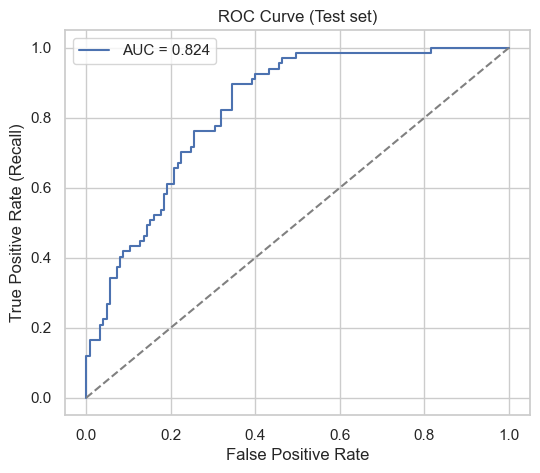

In [114]:

# Fit sklearn LogisticRegression (liblinear for small data)
clf = LogisticRegression(max_iter=1000, solver='liblinear')
clf.fit(X_train_s, y_train)

# Test set predicted probabilities and AUC
probs_test = clf.predict_proba(X_test_s)[:,1]
auc_test = roc_auc_score(y_test, probs_test)
print('Test AUC:', round(auc_test, 4))

# 5-fold CV AUC on training data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_auc = cross_val_score(clf, X_train_s, y_train, cv=cv, scoring='roc_auc')
print('5-fold CV AUC (train):', f'{cv_auc.mean():.4f} ± {cv_auc.std():.4f}')

# ROC curve plot
fpr, tpr, thr = roc_curve(y_test, probs_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_test:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (Test set)')
plt.legend()
plt.show()


In [116]:

pred_05 = (probs_test >= 0.5).astype(int)
print('Confusion matrix (threshold=0.5):')
print(confusion_matrix(y_test, pred_05))
print('\nClassification report:')
print(classification_report(y_test, pred_05, digits=3))


Confusion matrix (threshold=0.5):
[[105  20]
 [ 32  35]]

Classification report:
              precision    recall  f1-score   support

           0      0.766     0.840     0.802       125
           1      0.636     0.522     0.574        67

    accuracy                          0.729       192
   macro avg      0.701     0.681     0.688       192
weighted avg      0.721     0.729     0.722       192



In [118]:

cost_fn = 5
cost_fp = 1
ths = np.linspace(0.01, 0.99, 99)
costs = []
metrics = []

for t in ths:
    preds = (probs_test >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = cost_fn * fn + cost_fp * fp
    costs.append(total_cost)
    # store basic metrics
    recall = tp / (tp + fn) if (tp+fn)>0 else 0
    precision = tp / (tp + fp) if (tp+fp)>0 else 0
    metrics.append((t, total_cost, precision, recall))

best_idx = int(np.argmin(costs))
best_t = ths[best_idx]
best_cost = costs[best_idx]
print('Best threshold by cost:', best_t)
print('Corresponding expected cost (on test set):', best_cost)

# Show confusion at best threshold
pred_best = (probs_test >= best_t).astype(int)
print('\nConfusion matrix at best threshold:')
print(confusion_matrix(y_test, pred_best))
print('\nClassification report (best threshold):')
print(classification_report(y_test, pred_best, digits=3))


Best threshold by cost: 0.13
Corresponding expected cost (on test set): 69

Confusion matrix at best threshold:
[[61 64]
 [ 1 66]]

Classification report (best threshold):
              precision    recall  f1-score   support

           0      0.984     0.488     0.652       125
           1      0.508     0.985     0.670        67

    accuracy                          0.661       192
   macro avg      0.746     0.737     0.661       192
weighted avg      0.818     0.661     0.659       192



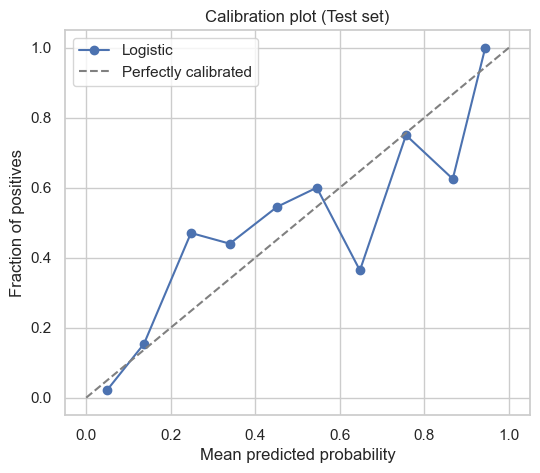

In [41]:

prob_true, prob_pred = calibration_curve(y_test, probs_test, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Logistic')
plt.plot([0,1],[0,1],'--', label='Perfectly calibrated', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot (Test set)')
plt.legend()
plt.show()


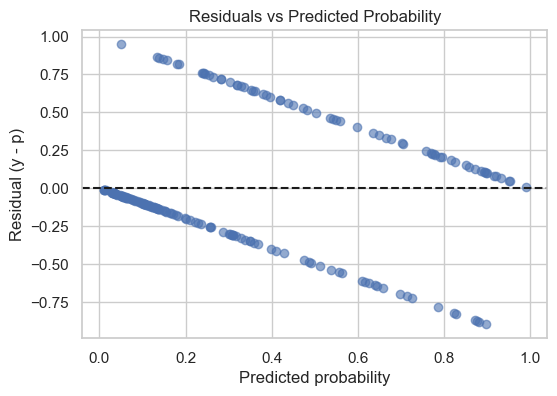

Outcome distribution (full dataset):
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [120]:

resid = y_test.values - probs_test
plt.figure(figsize=(6,4))
plt.scatter(probs_test, resid, alpha=0.6)
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Predicted probability')
plt.ylabel('Residual (y - p)')
plt.title('Residuals vs Predicted Probability')
plt.show()

# Check class balance
print('Outcome distribution (full dataset):')
print(df_clean['Outcome'].value_counts(normalize=True))
